---
title: "Wind Power Forecasting"
format:
    html:
        code-fold: true
jupyter: REStats
warning: false
echo: false
---

In [1]:
import os
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from albatross.analysis import plot_windrose, boxplot
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import arviz as az
import pymc as pm

from REStats.utils import load_SCADA

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# cmap = mpl.colormaps['tab10']
az.style.use("arviz-darkgrid")

## Data

The data consists of two years (2019-2020) of Wind Turbine data from the Kelmarsh Wind Farm in the UK.

Plumley, Charlie. Kelmarsh Wind Farm Data. Zenodo, 1 Feb. 2022. Zenodo, https://doi.org/10.5281/zenodo.5841834.


In [3]:
wt = load_SCADA(2020)

## Exploratory Data Analysis

In [4]:
wt.describe()

,Power,Wind direction,Wind speed
count,52236.000000,52236.000000,52236.000000
mean,716.467207,197.940539,6.524402
std,680.552771,91.136738,3.011010
min,-16.487485,0.014923,0.258319
25%,133.568163,142.185515,4.313493
50%,483.312851,217.529350,6.225888
75%,1194.308194,258.124086,8.311649
max,2078.528772,359.962357,22.419562


The wind speed distribution represents a typical right-skewed distribution, where we see the highest counts around 5-6 m/s

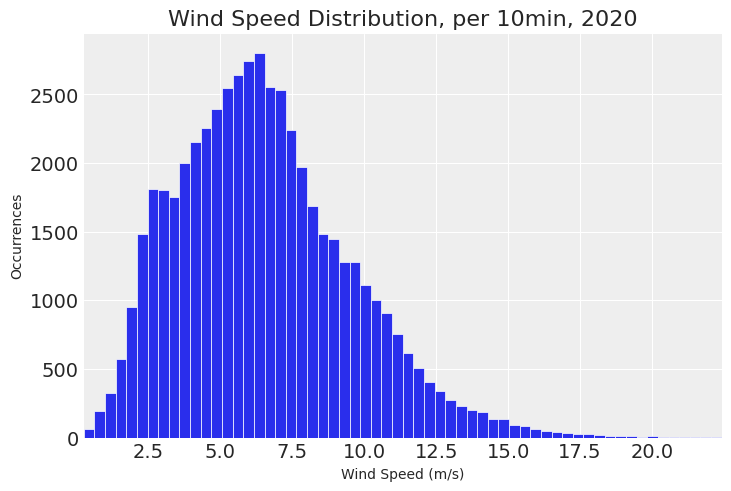

In [5]:
fig, ax = plt.subplots()

ax.set_title("Wind Speed Distribution, per 10min, 2020")
ax.set_xlabel("Wind Speed (m/s)")
ax.set_ylabel("Occurrences")
ax.set_xmargin(0)
ax.hist(wt["Wind speed"], 60, linewidth=0.5, edgecolor="white")
ax.grid(True)

#fig.savefig("ws_distribution.png")

A wind rose is a useful visualization that simultaneously characterizes wind speed and wind direction. The magnitude of a spoke represents the percentage of time in that direction. In this one we see that the predominant wind direction is SW.

/home/cam/workspace/projects/REStats/env/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
/home/cam/workspace/projects/REStats/env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


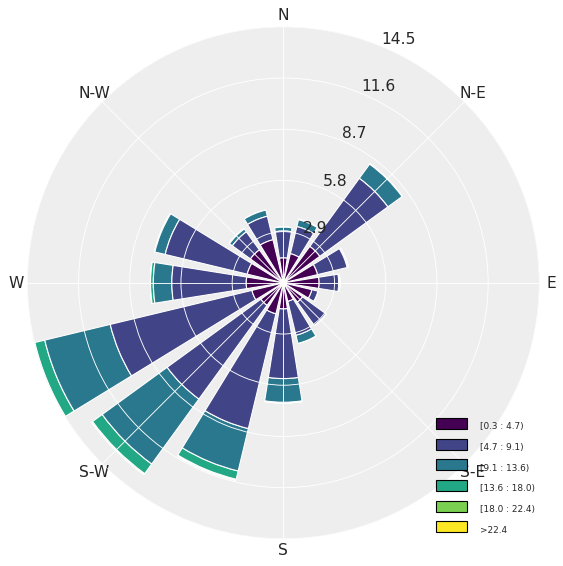

In [6]:
p = plot_windrose(wt.dropna(), speed="Wind speed", direction="Wind direction")
l = p.set_legend(loc="lower right")

We can also look at wind speed vs power output. We see that there is a strong correlation between the two, which is expected. There's an exception here in the middle of the day, where the power drops to zero. It looks like the turbine cut-in speed is around 2 m/s, meaning that it will shut off below that wind speed.

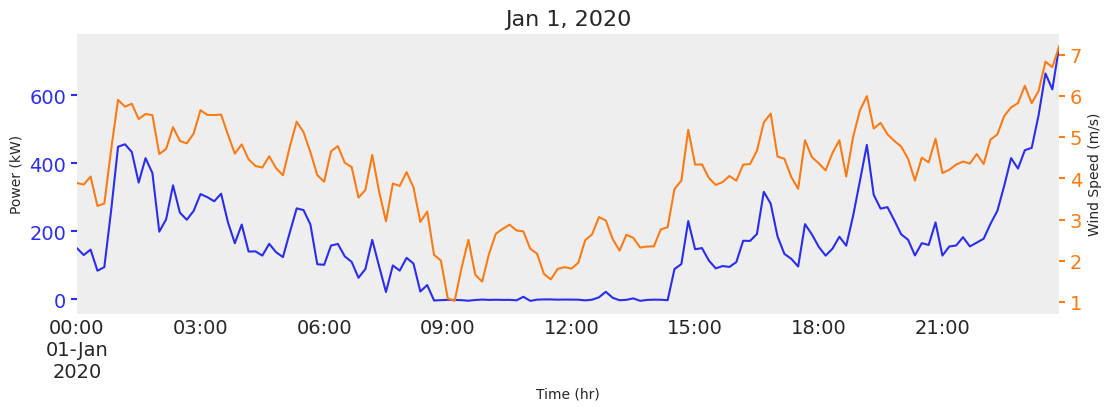

In [7]:
wt_1day = wt.loc[(wt.index >= "2020-01-01") & (wt.index < "2020-01-02")]

fig, ax = plt.subplots(figsize=(11, 4))

wt_1day["Power"].plot(ax=ax, color="C0")
right_ax = ax.twinx()
wt_1day["Wind speed"].plot(ax=right_ax, color="C1")

ax.grid(False)
right_ax.grid(False)
right_ax.axis('on')

ax.set_title("Jan 1, 2020")
ax.set_ylabel("Power (kW)")
ax.set_xmargin(0)
right_ax.set_xmargin(0)
ax.set_xlabel("Time (hr)")
ax.tick_params(axis='y', colors="C0", size=4, width=1.5)
right_ax.set_ylabel("Wind Speed (m/s)")
right_ax.tick_params(axis='y', colors="C1", size=4, width=1.5)

#fig.savefig("p_ws.png")

If we plot all of the observations of wind speed vs power, we get a representation of the turbine's power curve. As we saw before, it appears that the cut-in speed is around 2 m/s, and the rated power is around 2000 kW, or 2 MW. The turbine controls will prevent it from attempting to produce beyond that point, so the curve levels off at that power. Finally, we see that the cut-out speed is around 20 m/s, where the turbine will shut down to prevent damage from high winds.

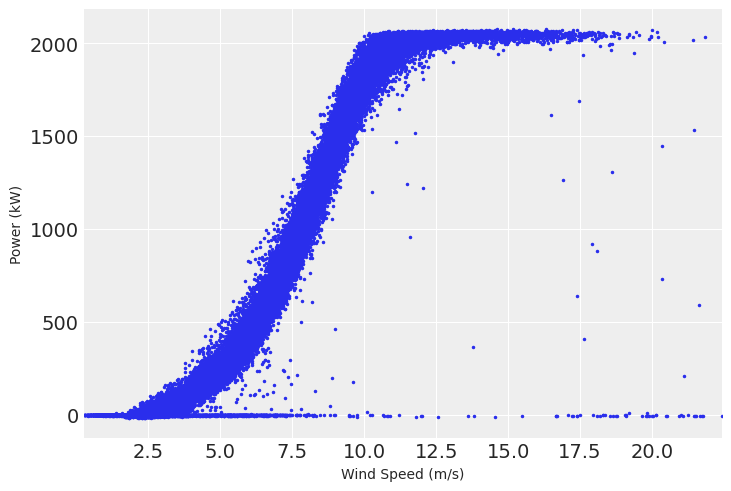

In [8]:
fig, ax = plt.subplots()
ax.plot(wt["Wind speed"], wt["Power"], "o", markersize=1.5)
ax.set_xlabel("Wind Speed (m/s)")
ax.set_ylabel("Power (kW)")
ax.set_xmargin(0)

# fig.savefig("power_curve.png")

This information is useful, but in order to form a forecasting model, we need to determine a feature set that incorporates an intuition about the past so that we can predict the future. One way to look at this is through autocorrelation: how does past power correlate with current power? We can explore this by calculating the correlation coefficients of current power with its past values, also called "lags". We see from the plot that current power is highly correlated with past power, up to a certain point. With this knowledge, we can attempt to build a model that uses these lags themselves as features!

/home/cam/workspace/projects/REStats/env/lib/python3.10/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/tmp/ipykernel_18213/3998789201.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


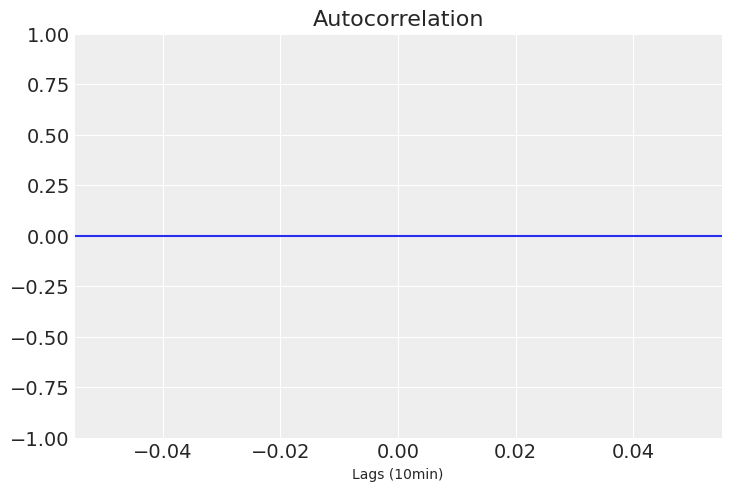

In [9]:
fig, ax = plt.subplots()
p = plot_acf(wt["Power"], lags=6, ax=ax)
ax.set_xlabel("Lags (10min)")

fig.show()

NameError: name 'power' is not defined

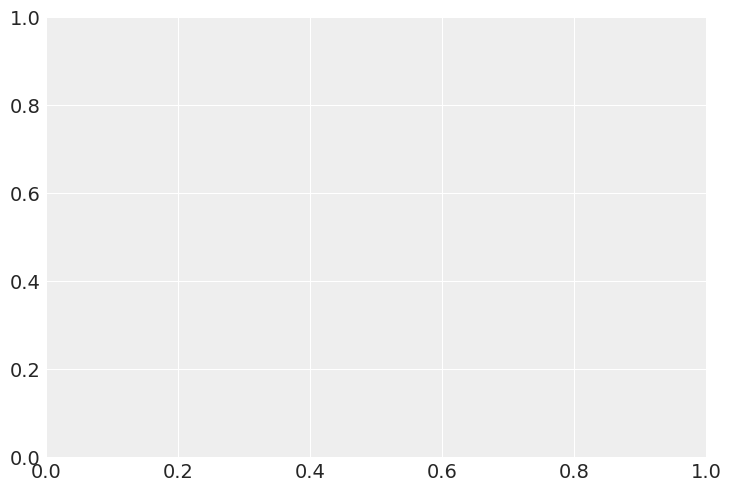

In [10]:
fig, ax = plt.subplots()

p = plot_pacf(power, lags=6, method="ywm", ax=ax)
ax.set_xlabel("Lags (10min)")

fig.show()

## Bayesian Approach

In standard regression, we model the power at a given time $y_t$ as a linear combination of its lagged values and parameter vector ${\rho}$,

$$
y_t = \alpha + \rho_1 y_{t-1} + ... + \rho_n y_{t-n}
$$

In a Bayesian approach, we model $y_t$ as following a normal distribution with mean $\mu_t$ and standard deviation $\sigma$. For example:

$$
\begin{align}
y_t & \sim \mathcal{N}(\mu_t, \sigma) \\
\mu_t & = \alpha + \rho_1 y_{t-1} + ... + \rho_n y_{t-n} \\
\alpha & \sim \mathcal{N}(0, 10) \\
\rho & \sim \mathcal{N}(0, 1) \\
\sigma & \sim \text{HalfNormal}(1) \\
\end{align} 
$$

This project proposes an AR(3) model with weakly informative priors,

$$
\begin{align}
y_t & \sim \mathcal{N}(\mu_t, \sigma) \\
\mu_t & = \rho_1 y_{t-1} + \rho_2 y_{t-2} + \rho_3 y_{t-3} \\
\rho & \sim \mathcal{N}(0, 1) \\
\sigma & \sim \text{HalfNormal}(1) \\
\end{align} 
$$


### Approach 1: Power -> Power

In [12]:
y_train = wt["Power"][(wt.index >= "2020-02-01") & (wt.index < "2020-03-01")]
ws = wt["Wind speed"][(wt.index >= "2020-02-01") & (wt.index < "2020-03-01")]

In [13]:
y_train.describe()

count    4176.000000
mean     1430.742769
std       702.828262
min       -15.841775
25%       883.534925
50%      1787.342171
75%      2031.961926
max      2073.927020
Name: Power, dtype: float64

In [14]:
#| output: false

y_train.isnull().sum() == 0

True

In [15]:
def standardize(data, train):
    return (data - train.mean())/train.std()


def inverse_transform(data, train):
    return data * train.std() + train.mean()

In [16]:
#| output: false

y_train_scaled = standardize(y_train, y_train)

with pm.Model() as model:
    rho = pm.Normal("rho", 0, 1, shape=3)
    tau = pm.Exponential("tau", 1)
    sigma = pm.HalfNormal("sigma", 1)

    mu = pm.AR(
        "mu", rho=rho, tau=tau, init_dist=pm.Normal.dist(0, 10), steps=len(y_train_scaled)-3
    )
    
    power = pm.Normal("power", mu=mu, sigma=sigma, observed=y_train_scaled)
    
    idata = pm.sample(2000, random_seed=100)
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: InplaceDimShuffle{}(TensorConstant{(1,) of 3})
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/home/cam/workspace/projects/REStats/env/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1925, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/home/cam/workspace/projects/REStats/env/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1084, in transform
    return self.fn(fgraph, node)
  File "/home/cam/workspace/projects/REStats/env/lib/python3.10/site-packages/pytensor/tensor/rewriting/basic.py", line 1141, in constant_folding
    thunk = node.op.make_thunk(node, storage_map, compute_map, no_recycling=[])
  File "/home/cam/workspace/projects/REStats/env/lib/python3.10/site-packages/pytensor/link/c/op.py", lin

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: InplaceDimShuffle{}(TensorConstant{(1,) of 3})
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/home/cam/workspace/projects/REStats/env/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1925, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/home/cam/workspace/projects/REStats/env/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1084, in transform
    return self.fn(fgraph, node)
  File "/home/cam/workspace/projects/REStats/env/lib/python3.10/site-packages/pytensor/tensor/rewriting/basic.py", line 1141, in constant_folding
    thunk = node.op.make_thunk(node, storage_map, compute_map, no_recycling=[])
  File "/home/cam/workspace/projects/REStats/env/lib/python3.10/site-packages/pytensor/link/c/op.py", lin

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: InplaceDimShuffle{}(TensorConstant{(1,) of 3})
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/home/cam/workspace/projects/REStats/env/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1925, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/home/cam/workspace/projects/REStats/env/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1084, in transform
    return self.fn(fgraph, node)
  File "/home/cam/workspace/projects/REStats/env/lib/python3.10/site-packages/pytensor/tensor/rewriting/basic.py", line 1141, in constant_folding
    thunk = node.op.make_thunk(node, storage_map, compute_map, no_recycling=[])
  File "/home/cam/workspace/projects/REStats/env/lib/python3.10/site-packages/pytensor/link/c/op.py", lin


You can find the C code in this temporary file: /tmp/pytensor_compilation_error_hj6yv4so

You can find the C code in this temporary file: /tmp/pytensor_compilation_error_x_760q78

You can find the C code in this temporary file: /tmp/pytensor_compilation_error_u9d8shz1

You can find the C code in this temporary file: /tmp/pytensor_compilation_error_7t5hy2pw

You can find the C code in this temporary file: /tmp/pytensor_compilation_error_fkpbuyf2

You can find the C code in this temporary file: /tmp/pytensor_compilation_error_czh1wbwr


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: InplaceDimShuffle{}(TensorConstant{(1,) of 3})
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/home/cam/workspace/projects/REStats/env/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1925, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/home/cam/workspace/projects/REStats/env/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1084, in transform
    return self.fn(fgraph, node)
  File "/home/cam/workspace/projects/REStats/env/lib/python3.10/site-packages/pytensor/tensor/rewriting/basic.py", line 1141, in constant_folding
    thunk = node.op.make_thunk(node, storage_map, compute_map, no_recycling=[])
  File "/home/cam/workspace/projects/REStats/env/lib/python3.10/site-packages/pytensor/link/c/op.py", lin


You can find the C code in this temporary file: /tmp/pytensor_compilation_error_fz18t9ut


ValueError: Could not infer ar_order from last dimension of rho. Pass it explicitly or make sure rho have a static shape

In [ ]:
az.summary(idata, var_names=("~mu"))

In [ ]:
p = az.plot_trace(idata, var_names=("~mu"))

The posterior predictive check shows that the model fits the observed data well at all but extreme values.

In [ ]:
p = az.plot_ppc(idata)

In [ ]:
post = idata.posterior
post_mean = post.mean(["chain", "draw"])

ppred = idata.posterior_predictive
ppred_mean = ppred.mean(["chain", "draw"])

In [ ]:
fig, ax = plt.subplots(figsize=(12, 7))

x = range(len(y_train))

ax.plot(y_train.index, y_train, label="Observed")
y_pred = ppred_mean.power.values * y_train.std() + y_train.mean()

ax.plot(y_train.index, y_pred, label="Predicted")
ax.set_ylabel("Power (kW)")
ax.legend()
# az.plot_hdi(, ppred.power)

fig.show()

In [ ]:
mae = sum(abs(y_pred - y_train))/len(y_pred)
print(f"MAE: {mae}")

In [ ]:
rmse = mean_squared_error(y_true=y_train, y_pred=y_pred, squared=False)
print(f"RMSE: {rmse}")

In [ ]:
y_test = wt["Power"][(wt.index > "2019-03-01") & (wt.index < "2019-03-02")]

In [ ]:
#| output: false

y_test.isnull().sum() == 0

In [ ]:
def predict(power, lags=3, steps=1):
    assert len(power) == lags
    
    predictions = np.flip(np.copy(power))
    
    for s in range(steps):
        pred = np.dot(post_mean.rho, predictions[-lags:])
        predictions = np.append(
            predictions, pred
        )
        
    return predictions[lags:]

In [ ]:
def backtest(data, lags, steps=1):
    predictions = np.zeros(len(data))
    current = 0
    rmse = np.zeros(len(data))
    mae = np.zeros(len(data))
    
    data_s = standardize(data, y_train)

    while current < len(data):
        if current < lags:
            predictions[current] = data[current]
            rmse[current] = 0
            mae[current] = 0
        else:
            window = data_s[(current-lags):current]
            pred_s = predict(window, lags=lags, steps=steps)
            pred = inverse_transform(pred_s, y_train)
            predictions[current] = pred[0]

            y_true = data[current:current+steps].values
    
            if len(y_true) == len(pred):
                rmse[current] = mean_squared_error(y_true=y_true, y_pred=pred, squared=False)
                mae[current] = sum(abs(y_true - pred))/len(pred)
                
        current += 1
        
    error = {
        "rmse": np.average(rmse),
        "mae": np.average(mae)
    }

    return error, predictions

For a backtest on the training data for 1 hour ahead forecasts (6 steps),

In [ ]:
err, predictions = backtest(y_test, 3, steps=6)
err

A chart describing a 10min (1 step) ahead backtest on unseen data shows that the model tracks well.

In [ ]:
fig, ax = plt.subplots()

ax.plot(y_test.index, predictions, label="Predicted")
y_test.plot(ax=ax, label="Observed")
ax.set_ylabel("Power (kW)")
ax.legend()

fig.show()

## Approach 2: Wind -> Power

The Power -> Power model works reasonably well, but it’s based on the assumption that wind power fits a Gaussian distribution (not necessarily true). This approach takes advantage of the fact that wind speeds follow a Weibull distribution. By fitting the curve to find the shape $\alpha$ and scale $\beta$ parameters, we can apply a transformation to make the curve more Gaussian, after which we can standardize the data as before.

In [ ]:
fig, ax = plt.subplots()

d = ax.hist(ws, bins=40)

In [ ]:
#| output: false

with pm.Model() as wb_model:
    alpha = pm.HalfNormal("alpha", 1)
    beta = pm.HalfNormal("beta", 1)
    weibull = pm.Weibull("weibull", alpha=alpha, beta=beta, observed=ws)
    
    idata_wb = pm.sample(2000, random_seed=100)
    pm.sample_posterior_predictive(idata_wb, extend_inferencedata=True)

In [ ]:
p = az.plot_trace(idata_wb)

In [ ]:
p = az.plot_ppc(idata_wb)

In [ ]:
post = idata_wb.posterior
p_mean = post.mean(["chain", "draw"])
p_mean

In [ ]:
shape = p_mean.alpha.item(0)
scale = p_mean.beta.item(0)

In [ ]:
fig, ax = plt.subplots()

ax.set_title("Fitted Wind Speed Distribution")
ax.set_xlabel("Wind Speed (m/s)")
p = az.plot_dist(scale*np.random.weibull(shape, 10000), ax=ax)

We can use the fitted Weibull distribution's shape parameter $\alpha$ to apply a transform to our wind speed data $V$ to make it more Gaussian,

$$
\hat{V} = V^m
$$

where

$$
m = \frac{\alpha}{3.6}
$$

Why 3.6? This is the shape parameter corresponding to a Weibull distribution with Gaussian shape.

In [ ]:
m = shape / 3.6
v = ws**m

print(f"m: {m}")

In [ ]:
fig, ax = plt.subplots()
ax.set_title("Wind Speed Distribution (Scaled and Standardized)")

dist = (scale*np.random.weibull(shape, 10000))**m
dist_std = standardize(dist, dist)
az.plot_dist(dist_std)

fig.show()

In [ ]:
#| output: false

v_train_scaled = standardize(v, v)

with pm.Model() as model_ws:
    rho = pm.Normal("rho", 0, 1, shape=3)
    tau = pm.Exponential("tau", 1)
    sigma = pm.HalfNormal("sigma", 1)

    mu = pm.AR(
        "mu", rho=rho, tau=tau, init_dist=pm.Normal.dist(0, 10), steps=len(v_train_scaled)-3
    )
    
    power = pm.Normal("windspeed", mu=mu, sigma=sigma, observed=v_train_scaled)
    
    idata_ws = pm.sample(2000, random_seed=100)
    pm.sample_posterior_predictive(idata_ws, extend_inferencedata=True)

The model needs some additional tuning, as the HMC chains show some disagreement in convergence. However, as we'll see, the posterior predictive checks show excellent agreement with the observed data.

In [ ]:
az.summary(idata_ws, var_names=("~mu"))

In [ ]:
p = az.plot_trace(idata_ws, var_names=("~mu"))

In [ ]:
p = az.plot_ppc(idata_ws)

In [ ]:
post = idata_ws.posterior
post_mean = post.mean(["chain", "draw"])

ppred = idata_ws.posterior_predictive
ppred_mean = ppred.mean(["chain", "draw"])

ws_pred = (ppred_mean.windspeed.values * v.std() + v.mean())**(1/m)
rmse = mean_squared_error(y_true=ws, y_pred=ws_pred, squared=False)
print(f"RMSE: {rmse}")

In [ ]:
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(ws.index, ws, label="Observed")

ax.plot(ws.index, ws_pred, label="Predicted")
ax.set_ylabel("Wind speed (m/s)")
ax.legend()
# az.plot_hdi(, ppred.power)

fig.show()

### Next steps

- Complete backtesting of wind forecasting model. The `backtest` function needs some more tweaking
- Incorporate HDI (uncertainty) intervals into plots. The data is there, just needs implementation
- Connect this model to a nonparametric Power curve model that incorporates wind speed, wind direction, and other environmental variables. An ensemble of regression trees would be a strong potential choice here (i.e. Bayesian Additive Regression Tree (BART)). Gaussian Process Regression is another potential choice
- Compare results against the Power -> Power model and investigate benefits of hybrid model over Power -> Power model
- Continue lit review
- Meet with NREL Atmosphere to Electrons to Grid (A2e2G) team members, who have recently done similar work for integration of wind systems into day-ahead power markets